In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import jax.numpy as jnp
from jax import random, lax, vmap
import jax
jax.config.update("jax_enable_x64", True)


In [2]:
def sqrt_mat(A):
    s, v = jnp.linalg.eigh(A)
    s_sqrt = s**(0.5) * (s>0.0)
    return v @ jnp.diag(s_sqrt) @ v.T 


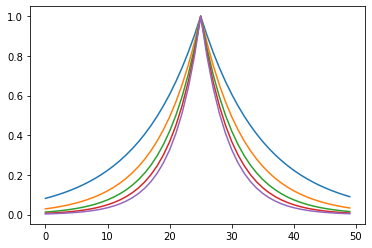

In [6]:

### TODOs: 
# 1. implement a GPU version, 2. make plot of MDP vs Gaussian equivalence in 2D grid world 3. Try predicting the MDP from theory

# GPU expt
T = 50
N = 300
tau = 1.5

exp_spec = 1.2

Sigma = np.zeros((N,T,T))
Sigma_shift = np.zeros((N,T,T))
taus = [ 10.0/np.sqrt(n+1) for n in range(N) ]

for t in range(T):
    for s in range(T):
        for k in range(N):
            Sigma[k,t,s] = (k+1)**(-exp_spec) * np.exp(- np.abs(t-s) / taus[k] )

    
for k in range(5):
    plt.plot(Sigma[k,T//2,:] / Sigma[k,T//2,T//2])
plt.show()

Sigma_diag = np.zeros(N)
Sigma_shift_diag = np.zeros(N)
for t in range(T-1):
    Sigma_shift_diag += Sigma[:,t,t+1]
    Sigma_diag += Sigma[:,t,t]

steps = 500
eta = 0.025
w = np.zeros(N)
w_expt = np.zeros(N)
exp_target = 1.1
wR = np.array( [ (n+1)**(-exp_target) for n in range(N) ] )

gamma = 0.9
batch = 5
sqrt_Sigma = np.zeros((N,T,T))
for k in range(N):
    sqrt_Sigma[k,:,:] = sqrt_mat(Sigma[k,:,:])

sqrt_Sigma = jnp.array(sqrt_Sigma)

all_w = []
all_w_expt = []

wV = Sigma_diag / (Sigma_diag - gamma * Sigma_shift_diag) * wR


In [3]:

# we will do a lax.scan call
def update_fn(w_key, x):
    w, key = w_key
    loss = jnp.sum((w-wV)**2 * Sigma_diag )
    Z = random.normal(key, (N,T, batch))
    psi = jnp.einsum('ijk,ikl->ijl', sqrt_Sigma, Z)
    psi0 = psi[:,:T-1,:]
    psi1 = psi[:,1:,:]
    
    # reward prediction error
    RPE = jnp.einsum('ijk,i->jk', psi0, wR-w) + gamma*jnp.einsum('ijk,i->jk', psi1, w)
    dw = eta/batch * jnp.einsum('ijk,jk->i', psi0, RPE)
    new_w = w + dw
    new_key, _ = random.split(key)
    return [new_w, new_key], loss


_, losses = lax.scan(update_fn, [jnp.zeros(N), random.PRNGKey(0)], xs=None, length = steps)



a = Sigma_diag - gamma * Sigma_shift_diag

def update_fn_th(mwbar,x):
    m, w_bar = mwbar
    loss = jnp.sum( m * Sigma_diag )
    # compute Q(t,s)
    Sigma0 = Sigma[:,:T-1,:T-1]
    Sigma1 = Sigma[:,:T-1,1:]
    Sigma2 = Sigma[:,1:,1:]
    ww = m + 2*(w_bar-wV)*wV + wV**2 # < w w > = < (w-w_V + wV) (w-w_V + wV) > = M + 2(<w>-wV)wV + wV wV
    # < (w-wR)^2 > = < w^2 > - 2 < w > wR + wR^2 
    w_wR_sqr = ww - 2*w_bar * wR + wR**2
    # (wR-w) * w = wR <w> - <ww>
    w_wR_cross = wR*w_bar - ww 
    
    Q = jnp.einsum('ijk,i->jk', Sigma0, w_wR_sqr) + gamma * jnp.einsum('ijk,i->jk', Sigma1, w_wR_cross) 
    Q += gamma * jnp.einsum('ijk,i->kj', Sigma1, w_wR_cross) + gamma**2 * jnp.einsum('ijk,i->jk', Sigma2, ww) 
    
    m_new = (1-eta*a)**2 * m + eta**2/ batch * jnp.einsum('ijk,jk->i',Sigma0,Q)
    w_bar_new = w_bar + eta*a*(wV-w_bar)
    return [m_new, w_bar_new], loss

m0 = wV**2    # m = < (w-w_V)^2 >
w_bar0 = np.zeros(N)

_, losses_th = lax.scan(update_fn_th, [m0,w_bar0], xs=None, length = steps)


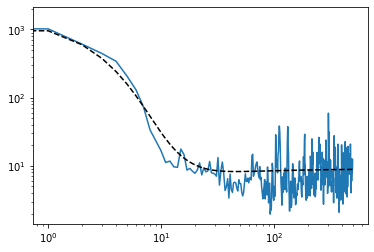

In [4]:
plt.loglog(losses)
plt.loglog(losses_th, '--', color = 'black')
plt.show()

In [5]:
get_losses = lambda keynum: lax.scan(update_fn, [jnp.zeros(N), random.PRNGKey(keynum)], xs=None, length = steps)[1]
all_losses = vmap(get_losses)(jnp.arange(20))

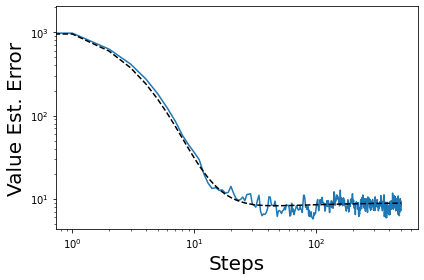

In [6]:
plt.loglog(all_losses.mean(axis = 0), label = 'Expt')
plt.loglog(losses_th, '--', color = 'black', label = 'Theory')
plt.xlabel(r'Steps', fontsize = 20)
plt.ylabel(f'Value Est. Error',fontsize = 20)
plt.tight_layout()

plt.show()

In [3]:
def expt_learn_curves(Sigma_diag, sqrt_Sigma, wR, wV, eta, gamma, batch, num_rep = 20, sigma = 0.0):
    
    def update_fn(w_key, x):
        w, key = w_key
        loss = jnp.sum((w-wV)**2 * Sigma_diag )
        Z = random.normal(key, (N,T, batch))
        psi = jnp.einsum('ijk,ikl->ijl', sqrt_Sigma, Z)
        psi0 = psi[:,:T-1,:]
        psi1 = psi[:,1:,:]
    
        # reward prediction error
        new_key, eps_key = random.split(key)

        RPE = jnp.einsum('ijk,i->jk', psi0, wR-w) + gamma*jnp.einsum('ijk,i->jk', psi1, w) + sigma*random.normal(eps_key, (psi0.shape[1],psi0.shape[2]))
        dw = eta/batch * jnp.einsum('ijk,jk->i', psi0, RPE)
        new_w = w + dw
        return [new_w, new_key], loss
    
    get_losses = lambda keynum: lax.scan(update_fn, [jnp.zeros(N), random.PRNGKey(keynum)], xs=None, length = steps)[1]
    all_losses = vmap(get_losses)(jnp.arange(20))
    
    return all_losses

def compute_theory(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, eta, gamma,batch, sigma = 0.0):
    
    
    a = Sigma_diag - gamma * Sigma_shift_diag

    def update_fn_th(mwbar,x):
        m, w_bar = mwbar
        loss = jnp.sum( m * Sigma_diag )
        # compute Q(t,s)
        Sigma0 = Sigma[:,:T-1,:T-1]
        Sigma1 = Sigma[:,:T-1,1:]
        Sigma2 = Sigma[:,1:,1:]
        ww = m + 2*(w_bar-wV)*wV + wV**2 # < w w > = < (w-w_V + wV) (w-w_V + wV) > = M + 2(<w>-wV)wV + wV wV
        # < (w-wR)^2 > = < w^2 > - 2 < w > wR + wR^2 
        w_wR_sqr = ww - 2*w_bar * wR + wR**2
        # (wR-w) * w = wR <w> - <ww>
        w_wR_cross = wR*w_bar - ww 
    
        Q = jnp.einsum('ijk,i->jk', Sigma0, w_wR_sqr) + gamma * jnp.einsum('ijk,i->jk', Sigma1, w_wR_cross) 
        Q += gamma * jnp.einsum('ijk,i->kj', Sigma1, w_wR_cross) + gamma**2 * jnp.einsum('ijk,i->jk', Sigma2, ww) 
        Q += sigma**2 * jnp.eye(Sigma0.shape[1])
        m_new = (1-eta*a)**2 * m + eta**2/ batch * jnp.einsum('ijk,jk->i',Sigma0,Q)
        w_bar_new = w_bar + eta*a*(wV-w_bar)
        return [m_new, w_bar_new], loss

    m0 = wV**2    # m = < (w-w_V)^2 >
    w_bar0 = np.zeros(N)
    _, losses_th = lax.scan(update_fn_th, [m0,w_bar0], xs=None, length = steps)
    return losses_th

In [6]:
batches = [1,5,10,25, 50]
all_all_losses = [ expt_learn_curves(Sigma_diag, sqrt_Sigma, wR, wV, eta, gamma, batch, num_rep = 20).mean(axis=0) for batch in batches]
all_all_losses_th = [ compute_theory(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, eta, gamma,batch) for batch in batches ] 

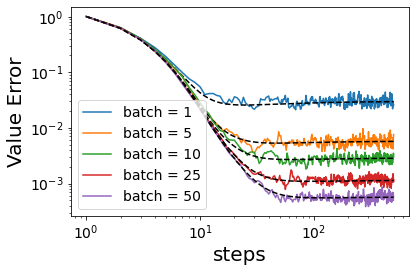

In [7]:
plt.rcParams.update({'font.size': 14})

for i, losses in enumerate(all_all_losses):
    length = len(losses)
    plt.loglog(jnp.linspace(1,length,length), losses / losses[0], label = f'batch = {batches[i]}')
    plt.loglog(jnp.linspace(1,length,length), all_all_losses_th[i] / all_all_losses_th[i][0],'--', color = 'black')
plt.legend()
plt.xlabel('steps',fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/vary_batch_gauss_decoupled.pdf')
plt.show()

In [8]:
batch = 10
gamma_vals = [0.1,0.25, 0.5, 0.8, 0.9]
all_losses_vary_gamma = []
all_losses_vary_gamma_th = []
for i, gamma in enumerate(gamma_vals):
    wV = Sigma_diag / (Sigma_diag - gamma * Sigma_shift_diag) * wR
    all_losses_vary_gamma += [ expt_learn_curves(Sigma_diag, sqrt_Sigma, wR, wV, eta, gamma, batch, num_rep = 20).mean(axis=0)]
    all_losses_vary_gamma_th += [ compute_theory(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, eta, gamma,batch)] 

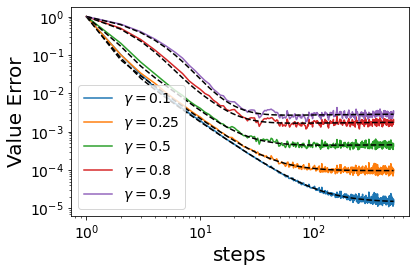

In [9]:
length = len(all_losses_vary_gamma[0])
for i, gamma in enumerate(gamma_vals):
    
    plt.loglog(jnp.linspace(1,length,length), all_losses_vary_gamma[i] / all_losses_vary_gamma[i][0], label = f'$\gamma = {gamma}$')
    plt.loglog(jnp.linspace(1,length,length), all_losses_vary_gamma_th[i]/all_losses_vary_gamma_th[i][0],'--', color = 'black')
plt.xlabel('steps',fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/vary_gamma_gauss_decoupled.pdf')
plt.show()

In [12]:
batch = 10
eta_vals = [ 0.01, 0.02, 0.05, 0.1]
gamma = 0.9
wV = Sigma_diag / (Sigma_diag - gamma * Sigma_shift_diag) * wR

all_losses_vary_eta = []
all_losses_vary_eta_th = []
for i, eta in enumerate(eta_vals):
    all_losses_vary_eta += [ expt_learn_curves(Sigma_diag, sqrt_Sigma, wR, wV, eta, gamma, batch, num_rep = 20).mean(axis=0)]
    all_losses_vary_eta_th += [ compute_theory(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, eta, gamma,batch)] 
    

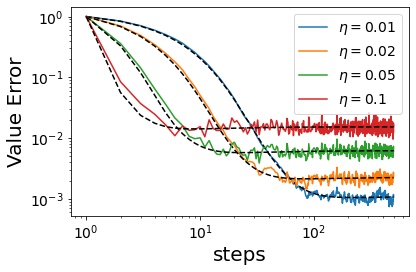

In [13]:
length = len(all_losses_vary_gamma[0])
for i, eta in enumerate(eta_vals):
    plt.loglog(jnp.linspace(1,length,length), all_losses_vary_eta[i] / all_losses_vary_eta[i][0], label = f'$\eta = {eta}$')
    plt.loglog(jnp.linspace(1,length,length), all_losses_vary_eta_th[i]/all_losses_vary_eta_th[i][0],'--', color = 'black')
plt.xlabel('steps',fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/vary_eta_gauss_decoupled.pdf')
plt.show()

### Learning Rate Schedules

In [4]:
def expt_learn_curves_schedule(Sigma_diag, sqrt_Sigma, wR, wV, eta, gamma, batch, num_rep = 20, sigma = 0.0, sch_exp = 0.0):
    
    # x counts the iterations
    def update_fn(w_key, x):
        w, key = w_key
        loss = jnp.sum((w-wV)**2 * Sigma_diag )
        Z = random.normal(key, (N,T, batch))
        psi = jnp.einsum('ijk,ikl->ijl', sqrt_Sigma, Z)
        psi0 = psi[:,:T-1,:]
        psi1 = psi[:,1:,:]
    
        # reward prediction error
        new_key, eps_key = random.split(key)
        eta_eff = eta * x**(-sch_exp)
        RPE = jnp.einsum('ijk,i->jk', psi0, wR-w) + gamma*jnp.einsum('ijk,i->jk', psi1, w) + sigma*random.normal(eps_key, (psi0.shape[1],psi0.shape[2]))
        dw = eta_eff/batch * jnp.einsum('ijk,jk->i', psi0, RPE)
        new_w = w + dw
        return [new_w, new_key], loss
    
    get_losses = lambda keynum: lax.scan(update_fn, [jnp.zeros(N), random.PRNGKey(keynum)], xs=jnp.linspace(1,steps,steps))[1]
    all_losses = vmap(get_losses)(jnp.arange(20))
    
    return all_losses

def compute_theory_schedule(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, eta, gamma,batch, sigma = 0.0, sch_exp = 0.0):
    
    
    a = Sigma_diag - gamma * Sigma_shift_diag
    
    # x counts the iterations
    def update_fn_th(mwbar,x):
        m, w_bar = mwbar
        loss = jnp.sum( m * Sigma_diag )
        # compute Q(t,s)
        Sigma0 = Sigma[:,:T-1,:T-1]
        Sigma1 = Sigma[:,:T-1,1:]
        Sigma2 = Sigma[:,1:,1:]
        ww = m + 2*(w_bar-wV)*wV + wV**2 # < w w > = < (w-w_V + wV) (w-w_V + wV) > = M + 2(<w>-wV)wV + wV wV
        # < (w-wR)^2 > = < w^2 > - 2 < w > wR + wR^2 
        w_wR_sqr = ww - 2*w_bar * wR + wR**2
        # (wR-w) * w = wR <w> - <ww>
        w_wR_cross = wR*w_bar - ww 
        eta_eff = eta * x**(-sch_exp)
        Q = jnp.einsum('ijk,i->jk', Sigma0, w_wR_sqr) + gamma * jnp.einsum('ijk,i->jk', Sigma1, w_wR_cross) 
        Q += gamma * jnp.einsum('ijk,i->kj', Sigma1, w_wR_cross) + gamma**2 * jnp.einsum('ijk,i->jk', Sigma2, ww) 
        Q += sigma**2 * jnp.eye(Sigma0.shape[1])
        m_new = (1-eta_eff*a)**2 * m + eta_eff**2/ batch * jnp.einsum('ijk,jk->i',Sigma0,Q)
        w_bar_new = w_bar + eta_eff*a*(wV-w_bar)
        return [m_new, w_bar_new], loss

    m0 = wV**2    # m = < (w-w_V)^2 >
    w_bar0 = np.zeros(N)
    _, losses_th = lax.scan(update_fn_th, [m0,w_bar0], xs=jnp.linspace(1,steps,steps))
    return losses_th

In [19]:
batch = 10
sch_vals = [ 0.0, 0.2, 0.75, 1.25 ]
gamma = 0.9
eta = 0.2
wV = Sigma_diag / (Sigma_diag - gamma * Sigma_shift_diag) * wR

all_losses_vary_sch = []
all_losses_vary_sch_th = []
for i, sch in enumerate(sch_vals):
    all_losses_vary_sch +=   [ expt_learn_curves_schedule(Sigma_diag, sqrt_Sigma, wR, wV, eta, gamma, batch, sch_exp=sch, num_rep = 20).mean(axis=0)]
    all_losses_vary_sch_th += [ compute_theory_schedule(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, eta, gamma, batch, sch_exp=sch)] 


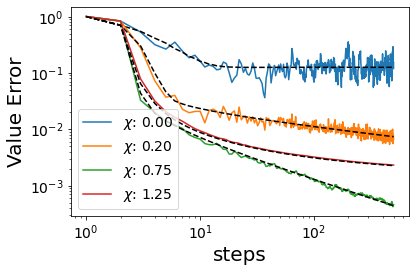

In [22]:
plt.rcParams.update({'font.size': 14})

length = len(all_losses_vary_sch[0])
for i, sch in enumerate(sch_vals):
    plt.loglog(jnp.linspace(1, length, length), all_losses_vary_sch[i] / all_losses_vary_sch[i][0], label = r'$\chi$: %0.2f' % sch)
    plt.loglog(jnp.linspace(1, length, length), all_losses_vary_sch_th[i] / all_losses_vary_sch_th[i][0],'--', color = 'black')
plt.xlabel('steps',fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/vary_lr_sch_gauss_decoupled.pdf')
plt.show()


In [23]:
batch = 10
sch_vals = np.linspace(0.0, 2.0, 20)
gamma = 0.9
eta = 0.2
wV = Sigma_diag / (Sigma_diag - gamma * Sigma_shift_diag) * wR

all_losses_vary_sch = []
all_losses_vary_sch_th = []
for i, sch in enumerate(sch_vals):
    all_losses_vary_sch +=   [ expt_learn_curves_schedule(Sigma_diag, sqrt_Sigma, wR, wV, eta, gamma, batch, sch_exp=sch, num_rep = 100).mean(axis=0)]
    all_losses_vary_sch_th += [ compute_theory_schedule(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, eta, gamma, batch, sch_exp=sch)] 


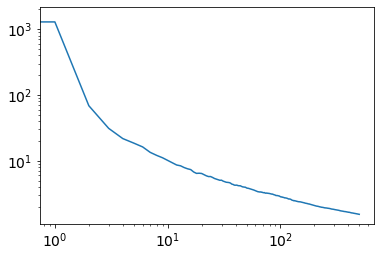

In [24]:
plt.loglog(all_losses_vary_sch[10])

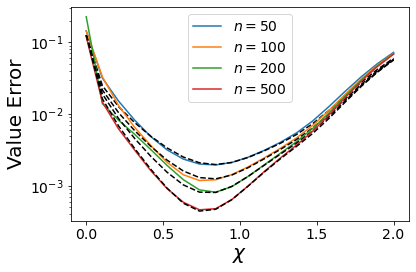

In [25]:
plot_times = [50, 100, 200, 500]
for pt in plot_times:
    plt.semilogy(sch_vals, jnp.array(all_losses_vary_sch)[:,pt] / jnp.array(all_losses_vary_sch)[:,0], label = f'$n = {pt}$')
    plt.semilogy(sch_vals, jnp.array(all_losses_vary_sch_th)[:,pt] / jnp.array(all_losses_vary_sch_th)[:,0], '--', color = 'black')

#plt.plot(chi)
plt.xlabel(r'$\chi$',fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/lr_sch_sweep_gauss_decoupled.pdf')
plt.show()

## A 2D Exploration MDP: Show Gaussian Equivalence Phenomenon and Theoretical Accuracy

In [51]:
# define MDP for random exploration
box_len = 17
# take in (x,y) coordinate and output new (x',y')
def update_fn(coord_key,x):
    coord, key = coord_key
    key_x, key_y,key_filt = random.split(key,3)
    x, y = coord
    
    dx = 2 * random.choice(key_x, 2) -1 # dx in {-1,1}
    dy = 2 * random.choice(key_y, 2) -1 # dx in {-1,1}
    
    filt = random.choice(key_filt, 2) # update only x or y but not both!
    new_key,_ = random.split(key_x)
    new_x = x + filt * dx
    new_y = y + (1-filt)*dy
    
    # now map to boundary, takes care of edge case
    new_x = (new_x>=box_len)*(x-1) + (new_x<0)*(x+1) + new_x *(new_x<box_len)*(new_x>=0)
    new_y = (new_y>=box_len)*(y-1) + (new_y<0)*(y+1) + new_y *(new_y<box_len)*(new_y>=0)

    new_coord = [ new_x, new_y ]
    return [new_coord, new_key], coord



In [52]:
_,coords = lax.scan(update_fn, [[box_len//2,box_len//2], random.PRNGKey(0)], None, length = 50)

In [53]:
num_samples = 10
get_coords = lambda seed: lax.scan(update_fn, [[box_len//2,box_len//2], random.PRNGKey(seed)], None, length = 100)[1]
all_coords = vmap(get_coords)(jnp.arange(num_samples))


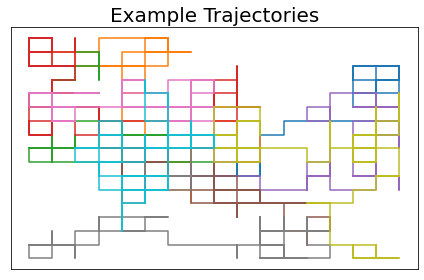

In [6]:
plt.figure()
for i in range(num_samples):
    plt.plot(all_coords[0][i,:],all_coords[1][i,:])
plt.xticks([])
plt.yticks([])
plt.title('Example Trajectories',fontsize = 20)
plt.tight_layout()
plt.savefig('figures/explore_2d_mdp.pdf', bbox_inches = 'tight')
plt.show()

In [11]:
def compute_transition_mat():
    Pi = np.zeros((box_len, box_len, box_len, box_len)) # (x,y), (x',y') is probability of going (x',y')->(x,y)
    
    # bulk: simple transition
    for i in range(1,box_len-1):
        for j in range(1,box_len-1):
            Pi[i+1,j,i,j] = 0.25
            Pi[i-1,j,i,j] = 0.25
            Pi[i,j-1,i,j] = 0.25
            Pi[i,j+1,i,j] = 0.25
    
    bm = box_len-1
    # edge conditions: bounce-back condition
    for i in range(1, box_len-1):
        Pi[1,i,0,i] = 0.5
        Pi[0,i+1,0,i] = 0.25
        Pi[0,i-1,0,i] = 0.25
        
        Pi[i,1,i,0] = 0.5
        Pi[i+1,0,i,0]=0.25
        Pi[i-1,0,i,0] =0.25
        
        Pi[bm-1,i,bm,i] = 0.5
        Pi[bm,i+1,bm,i] = 0.25
        Pi[bm,i-1,bm,i] = 0.25
        
        Pi[i,bm-1,i,bm] = 0.5
        Pi[i+1,bm,i,bm] = 0.25
        Pi[i-1,bm,i,bm] = 0.25
    
    # corner conditions
    Pi[0,1,0,0] = 0.5
    Pi[1,0,0,0] = 0.5
    
    Pi[bm,1,bm,0] = 0.5
    Pi[bm-1,0,bm,0] = 0.5
    
    Pi[1,bm,0,bm] = 0.5
    Pi[0,bm-1,0,bm] = 0.5
    
    Pi[bm-1,bm,bm,bm] = 0.5
    Pi[bm,bm-1,bm,bm] = 0.5
    return Pi



In [20]:
Pi = compute_transition_mat()

In [21]:
Pi = jnp.array(Pi)

In [22]:
print(Pi[:5,:5,0,0])
print(Pi[:5,:5,2,2])

[[0.  0.5 0.  0.  0. ]
 [0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.  ]
 [0.   0.25 0.   0.25 0.  ]
 [0.   0.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.  ]]


In [60]:
# compute two_point probability P(s_t= s, s_{t'} = s')
T = 50

powers_of_Pi = []
Pit = 1.0 * jnp.einsum('ik,jl->ijkl', jnp.eye(box_len), jnp.eye(box_len)) # identity map base case Pi^0
for t in range(T):
    powers_of_Pi += [ Pit  ]
    Pit = jnp.einsum('ijkl,klnm->ijnm',Pi, Pit)

NameError: name 'Pi' is not defined

In [54]:
# compute r_i[x,y] the neural code
# we will use a place cell code
def construct_code(sigma=2.5):
    N = box_len**2
    R = np.zeros((N,box_len,box_len))
    grid = np.linspace(0,box_len-1,box_len)
    for i in range(box_len):
        for j in range(box_len):
            dx2 = (grid - i)**2
            dy2 = (grid - j)**2
            dist = dx2[:,np.newaxis] + dy2[np.newaxis,:]
            R[i*box_len + j,:,:] = np.exp(-0.5 * dist/sigma**2)
    
    return R - R.mean(axis = (1,2))[:,np.newaxis,np.newaxis]

def construct_code_from_K(sigma=2.5):
    
    K = np.zeros((box_len, box_len, box_len, box_len))
    grid = np.linspace(0,box_len-1,box_len)
    for i in range(box_len):
        for j in range(box_len):
            dx2 = (grid - i)**2
            dy2 = (grid - j)**2
            dist = dx2[:,np.newaxis] + dy2[np.newaxis,:]
            K[i,j,:,:] = np.exp(-0.5/sigma**2 * dist )
    
    K_flat = K.reshape((K.shape[0]**2, K.shape[2]**2))
    s, v = jnp.linalg.eigh(K_flat)
    s = s * (s > 0.0 )
    indsort = jnp.argsort(s)[::-1]
    s = s[indsort]
    v = v[:,indsort]
    Psi_flat = jnp.diag(jnp.sqrt(s)) @ v.T # neurons x space
    Psi = Psi_flat.reshape((Psi_flat.shape[0], K.shape[2], K.shape[3]))
    return Psi



def construct_target_fn(sigma=2.5, dist_mult=1):
    
    R = np.zeros((box_len,box_len))
    grid = np.linspace(0,box_len-1,box_len)
    i = box_len//2 + dist_mult*box_len//5
    j = box_len//2 + dist_mult*box_len//5

    dx2 = (grid - i)**2
    dy2 = (grid - j)**2
    dist = dx2[:,np.newaxis] + dy2[np.newaxis,:]
    R = np.exp(-0.5 * dist/sigma**2)
    return R - R.mean()

Psi = construct_code()
#Psi = construct_code_from_K()
N = Psi.shape[0]
R = construct_target_fn()


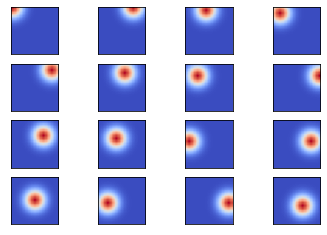

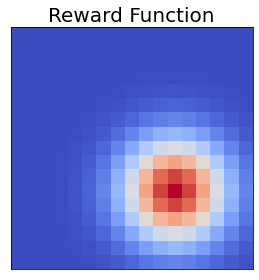

In [8]:
plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(Psi[12*i], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
plt.savefig('figures/place_cell_2d.pdf', bbox_inches = 'tight')
plt.show()

plt.imshow(R, cmap = 'coolwarm')
plt.xticks([])
plt.yticks([])
plt.title('Reward Function',fontsize = 20)
plt.tight_layout()
plt.savefig('figures/reward_vis_2d.pdf', bbox_inches = 'tight')
plt.show()

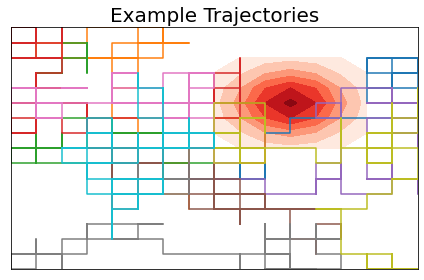

In [10]:
plt.figure()
R_plot = construct_target_fn(sigma = 1.5)
R_plot2 = np.zeros(R_plot.shape)
for i in range(R_plot.shape[0]):
    for j in range(R_plot.shape[1]):
        if R_plot[i,j] > 0.0:
            R_plot2[i,j] = R_plot[i,j]
        else:
            R_plot2[i,j] = np.nan

plt.contourf(R_plot2,cmap='Reds')
for i in range(num_samples):
    plt.plot(all_coords[0][i,:],all_coords[1][i,:])
#R_plot = R * (R>0.0) 

plt.xticks([])
plt.yticks([])
plt.title('Example Trajectories',fontsize = 20)
plt.tight_layout()
plt.savefig('figures/explore_2d_mdp_w_reward.pdf', bbox_inches = 'tight')
plt.show()

In [55]:
samples = 5200
T = 51
get_coords = lambda seed: lax.scan(update_fn, [[box_len//2,box_len//2], random.PRNGKey(seed)], None, length = T)[1]
all_coords = vmap(get_coords)(jnp.arange(samples))


In [56]:
print( all_coords[0].shape)
print(all_coords[1].shape )
Psi_visits = Psi[:,all_coords[0],all_coords[1]] # should be like N x samples x T
print(Psi_visits.dtype)
print(Psi.shape)

(5200, 51)
(5200, 51)
float64
(289, 17, 17)


In [57]:
Sigma_emp = 1/Psi_visits.shape[1] * jnp.einsum('ijk,ljm->iklm', Psi_visits, Psi_visits)
print(Sigma_emp.dtype)
Sigma_emp = jnp.array(Sigma_emp, dtype= jnp.float64)
Sigma_flat = Sigma_emp.reshape((Sigma_emp.shape[0]*Sigma_emp.shape[1], Sigma_emp.shape[0]*Sigma_emp.shape[1]))
sqrt_Sigma = sqrt_mat(Sigma_flat)
sqrt_Sigma= sqrt_Sigma.reshape(Sigma_emp.shape)

float64


In [50]:
A = jnp.ones((10,10), dtype = jnp.float64)
sqrt_A = sqrt_mat(A)

In [17]:
print("symmetry check")
print( jnp.amax( ( Sigma_flat.T - Sigma_flat)**2 ) )

symmetry check
0.0


In [79]:
print(Sigma_emp.shape)

(289, 51, 289, 51)


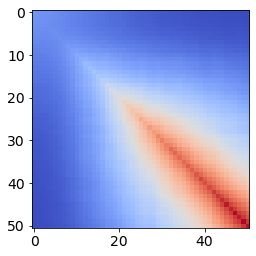

In [80]:
plt.imshow( Sigma_emp[5,:,5,:],cmap = 'coolwarm')
plt.show()

In [58]:
# train with Sigma_emp and compare to training with actual sampling
# R is reward function
def TD_MDP(eta, gamma, R, batch = 10, num_steps = 500, sigma = 0.0):

    # compute wR, wV
    
    rvec = R.reshape((R.shape[0]*R.shape[1]))
    psi_vec = Psi.reshape((Psi.shape[0],Psi.shape[1]*Psi.shape[2]))
    
    # solve Psi w = r
    u, s, v = jnp.linalg.svd(psi_vec)
    print("max sv of Psi")
    print(jnp.amax(s))
    s_inv = (s>0.0) * (s+1e-6)**(-1.0)
    wR = u @ jnp.diag(s_inv) @ v @ rvec
    
    
    Sigma_bar = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,:-1])
    Sigma_bar_shift = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,1:])
    wV = jnp.linalg.solve(Sigma_bar - gamma * Sigma_bar_shift + 1e-8*jnp.eye(Sigma_bar.shape[0]), Sigma_bar @ wR)
    
    print(jnp.mean(wV**2))
    sample_nums = jnp.arange(batch)
    w = jnp.zeros(wR.shape[0])
    
    print(w.shape)
    print(wR.shape)
    print(wV.shape)
    print(Psi.shape)
    
    losses = []
    for n in range(num_steps):   
        loss = jnp.dot( (w-wV), Sigma_bar @ (w-wV) )
        losses += [loss]

        all_coords = vmap(get_coords)(sample_nums)
        sample_nums += jnp.ones(sample_nums.shape[0], dtype=jnp.int32) * sample_nums.shape[0]
        
        Psi_vis = Psi[:,all_coords[0],all_coords[1]] # N x B x T
        Psi0 = Psi_vis[:,:,:-1]
        Psi1 = Psi_vis[:,:,1:]
        
        RPE = jnp.einsum('ijk,i->jk', Psi0 ,wR-w) + gamma * jnp.einsum('ijk,i->jk', Psi1 ,w) + sigma * random.normal(random.PRNGKey(n), (Psi0.shape[1],Psi0.shape[2]))
        w = w + eta/batch * jnp.einsum('ijk,jk->i', Psi0, RPE)
    return losses

def TD_Gauss(eta, gamma, R, batch = 10, num_steps = 500, sigma = 0.0):

    # compute wR, wV
    
    rvec = R.reshape((R.shape[0]*R.shape[1]))
    psi_vec = Psi.reshape((Psi.shape[0],Psi.shape[1]*Psi.shape[2]))
    
    # solve Psi w = r
    u, s, v = jnp.linalg.svd(psi_vec)
    s_inv = (s>0.0) * (s+1e-6)**(-1.0)
    wR = u @ jnp.diag(s_inv) @ v @ rvec
    
    
    Sigma_bar = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,:-1])
    Sigma_bar_shift = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,1:])
    wV = jnp.linalg.solve(Sigma_bar - gamma * Sigma_bar_shift + 1e-8*jnp.eye(Sigma_bar.shape[0]), Sigma_bar @ wR)
    
    sample_nums = jnp.arange(batch)
    w = jnp.zeros(wR.shape[0])
        
    key = random.PRNGKey(0)
    losses = []
    
    for n in range(num_steps):   
        loss = jnp.dot( (w-wV), Sigma_bar @ (w-wV) )
        losses += [loss]
        Z = random.normal(key,(N,T,batch)) # 
        Psi_vis = jnp.einsum('ijkl,klm->imj', sqrt_Sigma, Z) # N x B x T

        key, _ = random.split(key)
        
        #all_coords = vmap(get_coords)(sample_nums)
        #sample_nums += jnp.ones(sample_nums.shape[0], dtype=jnp.int32) * sample_nums.shape[0]
        
        Psi0 = Psi_vis[:,:,:-1]
        Psi1 = Psi_vis[:,:,1:]
        
        RPE = jnp.einsum('ijk,i->jk', Psi0 ,wR-w) + gamma * jnp.einsum('ijk,i->jk', Psi1 ,w) + sigma * random.normal(random.PRNGKey(n), (Psi0.shape[1],Psi0.shape[2]))
        w = w + eta/batch * jnp.einsum('ijk,jk->i', Psi0, RPE)
        
    return losses

In [64]:
eta = 0.01
gamma = 0.8
losses_MDP = TD_MDP(eta, gamma, R)
losses_Gauss = TD_Gauss(eta, gamma, R)

max sv of Psi
26.71646052401593
23.388380384004975
(289,)
(289,)
(289,)
(289, 17, 17)


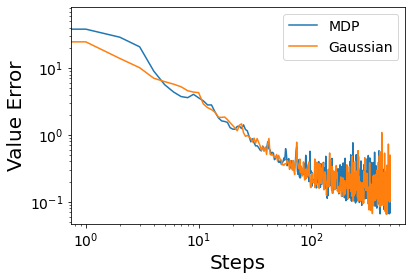

0.6440086202247213


In [65]:
plt.rcParams.update({'font.size': 14})

plt.loglog(losses_MDP, label = 'MDP')
plt.loglog(losses_Gauss, label = 'Gaussian')
plt.xlabel('Steps',fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.show()
print(np.array(losses_MDP).mean())

In [61]:
def TD_theory_MDP(eta, gamma, R, batch = 10, num_steps = 500, sigma = 0.0):
    
    
    rvec = R.reshape((R.shape[0]*R.shape[1]))
    psi_vec = Psi.reshape((Psi.shape[0],Psi.shape[1]*Psi.shape[2]))
    
    # solve Psi w = r
    u, s, v = jnp.linalg.svd(psi_vec)
    s_inv = (s>0.0) * (s+1e-6)**(-1.0)
    wR = u @ jnp.diag(s_inv) @ v @ rvec
    
    
    Sigma_bar = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,:-1])
    
    print("minimum eigenvalue of Sigma_bar")
    print(jnp.amin(jnp.linalg.eigvalsh(Sigma_bar)))
    Sigma_bar_shift = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,1:])
    wV = jnp.linalg.solve(Sigma_bar - gamma * Sigma_bar_shift + 1e-8*jnp.eye(Sigma_bar.shape[0]), Sigma_bar @ wR)
    
    N = wV.shape[0]
    
    # average weight
    wbar = jnp.zeros(N)

    # error covariance
    M = jnp.outer(wV,wV)
    
    A = jnp.eye(N) - eta * ( Sigma_bar - gamma*Sigma_bar_shift )
    
    Sigma0 = Sigma_emp[:,:-1,:,:-1]
    Sigma1 = Sigma_emp[:,:-1,:,1:]
    Sigma2 = Sigma_emp[:,1:,:,1:]
    
    losses = [ ]
    for n in range(num_steps):
        
        losses += [ jnp.sum( M * Sigma_bar ) ]
        ww = M + jnp.outer(wbar-wV,wV) + jnp.outer(wV, wbar-wV) + jnp.outer(wV,wV)
        w_wR_sqr = ww - jnp.outer(wbar,wR) - jnp.outer(wR,wbar) + jnp.outer(wR,wR)
        w_wR_cross = jnp.outer(wR,wbar) - ww
        
        
        
        Q = jnp.einsum('ijkl,ik->jl', Sigma0, w_wR_sqr) # calculate
        Q += gamma * jnp.einsum('ijkl,ik->jl', Sigma1, w_wR_cross) + gamma * jnp.einsum('ijkl,ik->lj', Sigma1, w_wR_cross)
        Q += gamma**2 * jnp.einsum('ijkl,ik->jl', Sigma2, ww)
        Q += sigma**2 * jnp.eye(Q.shape[0])
        
        M = A @ M @ A.T + eta**2 / batch * jnp.einsum('ijkl,jl->ik', Sigma0, Q)
        wbar = wbar + eta * ( Sigma_bar - gamma*Sigma_bar_shift ) @ (wV - wbar)
        
    return losses

In [66]:
losses_th = TD_theory_MDP(eta, gamma, R)

minimum eigenvalue of Sigma_bar
-7.650973214511549e-13


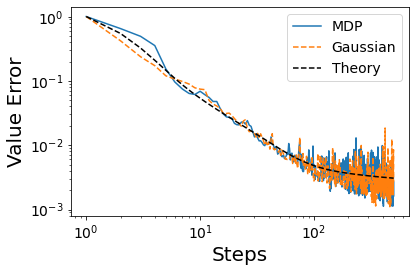

In [67]:
plt.rcParams.update({'font.size': 14})

length = len(losses_MDP)
plt.loglog(np.linspace(1,length,length), np.array(losses_MDP) / losses_MDP[0], label = 'MDP')
plt.loglog(np.linspace(1,length,length), np.array(losses_Gauss) / losses_Gauss[0], '--', label = 'Gaussian')
plt.loglog(np.linspace(1,length,length), np.array(losses_th) / losses_th[0], '--', color = 'black', label = 'Theory')
plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/value_err_2d_explore_mdp_gaussequiv.pdf')
plt.show()

In [206]:
eta = 0.01
gamma = 0.8
sigma = 2.5
batch = 10

losses_MDP = TD_MDP(eta, gamma, R, sigma=sigma, batch=batch)
losses_Gauss = TD_Gauss(eta, gamma, R, sigma = sigma,batch = batch)
losses_th = TD_theory_MDP(eta, gamma, R, sigma = sigma,batch = batch)

max sv of Psi
5.878886
13.048069
(361,)
(361,)
(361,)
(361, 19, 19)
minimum eigenvalue of Sigma_bar
-2.3610691e-09


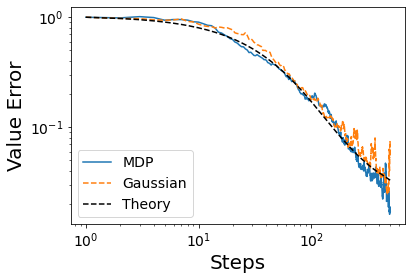

In [207]:
length = len(losses_MDP)
plt.loglog(np.linspace(1,length,length), np.array(losses_MDP) / losses_MDP[0], label = 'MDP')
plt.loglog(np.linspace(1,length,length), np.array(losses_Gauss) / losses_Gauss[0], '--', label = 'Gaussian')
plt.loglog(np.linspace(1,length,length), np.array(losses_th) / losses_th[0], '--', color = 'black', label = 'Theory')
plt.xlabel('Steps',fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.show()

In [25]:
from tqdm import tqdm

def get_emp_Sigma(Psi, samples = 5200):
    get_coords = lambda seed: lax.scan(update_fn, [[box_len//2,box_len//2], random.PRNGKey(seed)], None, length = T)[1]
    all_coords = vmap(get_coords)(jnp.arange(samples))
    Psi_visits = Psi[:,all_coords[0],all_coords[1]]
    Sigma_emp = 1/Psi_visits.shape[1] * jnp.einsum('ijk,ljm->iklm', Psi_visits, Psi_visits)

    Sigma_flat = Sigma_emp.reshape((Sigma_emp.shape[0]*Sigma_emp.shape[1], Sigma_emp.shape[0]*Sigma_emp.shape[1]))
    #sqrt_Sigma = sqrt_mat(Sigma_flat)
    #sqrt_Sigma= sqrt_Sigma.reshape(Sigma_emp.shape)
    return Sigma_emp

def TD_MDP_passPsi(Psi, Sigma_emp, eta, gamma, R, batch = 5, num_steps = 500, sigma = 0.0):

    # compute wR, wV
    
    rvec = R.reshape((R.shape[0]*R.shape[1]))
    psi_vec = Psi.reshape((Psi.shape[0],Psi.shape[1]*Psi.shape[2]))
    
    # solve Psi w = r
    u, s, v = jnp.linalg.svd(psi_vec)
    s_inv = (s>0.0) * (s+1e-6)**(-1.0)
    wR = u @ jnp.diag(s_inv) @ v @ rvec
    
    
    Sigma_bar = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,:-1])
    Sigma_bar_shift = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,1:])
    wV = jnp.linalg.solve(Sigma_bar - gamma * Sigma_bar_shift + 1e-6*jnp.eye(Sigma_bar.shape[0]), Sigma_bar @ wR)
    
    print(jnp.mean(wV**2))
    sample_nums = jnp.arange(batch)
    w = jnp.zeros(wR.shape[0])
    
    print(w.shape)
    print(wR.shape)
    print(wV.shape)
    print(Psi.shape)
    
    losses = []
    for n in range(num_steps):   
        loss = jnp.dot( (w-wV), Sigma_bar @ (w-wV) )
        losses += [loss]

        all_coords = vmap(get_coords)(sample_nums)
        sample_nums += jnp.ones(sample_nums.shape[0], dtype=jnp.int32) * sample_nums.shape[0]
        
        Psi_vis = Psi[:,all_coords[0],all_coords[1]] # N x B x T
        Psi0 = Psi_vis[:,:,:-1]
        Psi1 = Psi_vis[:,:,1:]
        
        RPE = jnp.einsum('ijk,i->jk', Psi0 ,wR-w) + gamma * jnp.einsum('ijk,i->jk', Psi1 ,w) + sigma * random.normal(random.PRNGKey(n), (Psi0.shape[1],Psi0.shape[2]))
        w = w + eta/batch * jnp.einsum('ijk,jk->i', Psi0, RPE)
    return losses

def TD_theory_MDP_passSigma(Sigma_emp, eta, gamma, R, batch = 5, num_steps = 500, sigma = 0.0):    
    rvec = R.reshape((R.shape[0]*R.shape[1]))
    psi_vec = Psi.reshape((Psi.shape[0],Psi.shape[1]*Psi.shape[2]))
    
    # solve Psi w = r
    u, s, v = jnp.linalg.svd(psi_vec)
    s_inv = (s>0.0) * (s+1e-6)**(-1.0)
    wR = u @ jnp.diag(s_inv) @ v @ rvec
    
    
    Sigma_bar = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,:-1])
    Sigma_bar_shift = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,1:])
    wV = jnp.linalg.solve(Sigma_bar - gamma * Sigma_bar_shift + 1e-6*jnp.eye(Sigma_bar.shape[0]), Sigma_bar @ wR)
    
    N = wV.shape[0]
    
    # average weight
    wbar = jnp.zeros(N)

    # error covariance
    M = jnp.outer(wV,wV)
    
    A = jnp.eye(N) - eta * ( Sigma_bar - gamma*Sigma_bar_shift )
    
    Sigma0 = Sigma_emp[:,:-1,:,:-1]
    Sigma1 = Sigma_emp[:,:-1,:,1:]
    Sigma2 = Sigma_emp[:,1:,:,1:]
    
    losses = [ ]
    for n in range(num_steps):
        
        losses += [ jnp.sum( M * Sigma_bar ) ]
        ww = M + jnp.outer(wbar-wV,wV) + jnp.outer(wV, wbar-wV) + jnp.outer(wV,wV)
        w_wR_sqr = ww - jnp.outer(wbar,wR) - jnp.outer(wR,wbar) + jnp.outer(wR,wR)
        w_wR_cross = jnp.outer(wR,wbar) - ww        
        
        Q = jnp.einsum('ijkl,ik->jl', Sigma0, w_wR_sqr) # calculate
        Q += gamma * jnp.einsum('ijkl,ik->jl', Sigma1, w_wR_cross) + gamma * jnp.einsum('ijkl,ik->lj', Sigma1, w_wR_cross)
        Q += gamma**2 * jnp.einsum('ijkl,ik->jl', Sigma2, ww)
        Q += sigma**2 * jnp.eye(Q.shape[0])
        M = A @ M @ A.T + eta**2 / batch * jnp.einsum('ijkl,jl->ik', Sigma0, Q)
        wbar = wbar + eta * ( Sigma_bar - gamma*Sigma_bar_shift ) @ (wV - wbar)
        
    return losses


def get_spectral_decomp_R_A(Sigma_emp, gamma, R):
        
    rvec = R.reshape((R.shape[0]*R.shape[1]))
    psi_vec = Psi.reshape((Psi.shape[0],Psi.shape[1]*Psi.shape[2]))
    
    # solve Psi w = r
    u, s, v = jnp.linalg.svd(psi_vec)
    s_inv = (s>0.0) * (s+1e-6)**(-1.0)
    wR = u @ jnp.diag(s_inv) @ v @ rvec
    
    Sigma_bar = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,:-1])
    Sigma_bar_shift = jnp.einsum('ijkj->ik', Sigma_emp[:,:-1,:,1:])
    wV = jnp.linalg.solve(Sigma_bar - gamma * Sigma_bar_shift + 1e-6*jnp.eye(Sigma_bar.shape[0]), Sigma_bar @ wR)
    
    # now do spectral decomp of A
    A = Sigma_bar - gamma * Sigma_bar_shift    
    return A, wV


In [40]:
place_cell_widths = [0.25, 0.5, 0.75, 1.0]
all_loss_MDP = []
all_loss_th = []
eta = 0.1
gamma = 0.85
batch = 2
for i, width in enumerate(place_cell_widths):
    Psi = construct_code(sigma = width)
    N = Psi.shape[0]
    R = construct_target_fn(sigma = 0.75)
    Sigma_emp = get_emp_Sigma(Psi)
    losses_MDP = TD_MDP_passPsi(Psi, Sigma_emp, eta, gamma, R, batch=batch)
    losses_th = TD_theory_MDP_passSigma(Sigma_emp, eta, gamma, R, batch = batch)
    all_loss_MDP += [losses_MDP]
    all_loss_th += [losses_th]

0.060926704123045065
(289,)
(289,)
(289,)
(289, 17, 17)
0.027534476236358345
(289,)
(289,)
(289,)
(289, 17, 17)
0.009480170225347827
(289,)
(289,)
(289,)
(289, 17, 17)
0.03766658635466903
(289,)
(289,)
(289,)
(289, 17, 17)


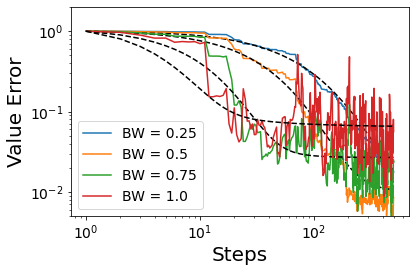

In [41]:
plt.rcParams.update({'font.size': 14})
for i, loss_MDP in enumerate(all_loss_MDP):
    plt.loglog(np.linspace(1,length,length), np.array(loss_MDP) / loss_MDP[0], label = f'BW = {place_cell_widths[i]}')
    #plt.loglog(np.linspace(1,length,length), np.array(losses_Gauss) / losses_Gauss[0], '--', label = 'Gaussian')
    plt.loglog(np.linspace(1,length,length), np.array(all_loss_th[i]) / all_loss_th[i][0], '--', color = 'black')
plt.xlabel('Steps',fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
plt.legend()
plt.ylim([5e-3,2.0])
plt.tight_layout()
plt.savefig(f'figures/vary_place_width_fourvals_2d_MDP_batch_{batch}.pdf')
plt.show()

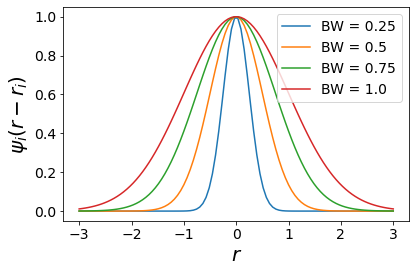

In [37]:
x = jnp.linspace(-3,3,100)
for i, width in enumerate(place_cell_widths):
    plt.plot(x, jnp.exp(- 0.5/width**2 * x**2 ), label = f'BW = {width}')
#plt.plot(x, jnp.exp(-0.5/8**2 * x**2), color = 'black', label = 'reward')
plt.xlabel(r'$r$',fontsize = 20)
plt.ylabel(r'$\psi_i(r-r_i)$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(r'figures/place_fields_vary_BW_fourvals.pdf')
plt.show()


### Vary Reward Function and Examine $C(k)$

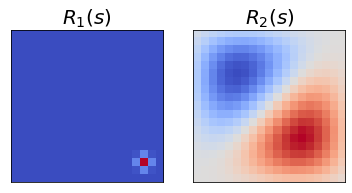

In [389]:
R1 = construct_target_fn(sigma = 0.5, dist_mult=2)
Psi_spec = construct_code_from_K(sigma = 1.0)
#weights = jnp.linspace(1,Psi_spec.shape[0],Psi_spec.shape[0])**(-2.5)
weights = np.zeros(Psi_spec.shape[0])
weights[2] = 1.0

R2 = jnp.einsum('ijk,i->jk', Psi_spec, weights)

gamma = 0.75

Sigma_emp = get_emp_Sigma(Psi_spec)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(R1, cmap= 'coolwarm')
plt.title(r'$R_1(s)$',fontsize = 20)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(R2, cmap = 'coolwarm')
plt.title(r'$R_2(s)$',fontsize = 20)
plt.xticks([])
plt.yticks([])
plt.savefig('figures/compare_reward_fns_visual.pdf', bbox_inches = 'tight')
plt.show()

A, wV1 = get_spectral_decomp_R_A(Sigma_emp, gamma, R1)
_, wV2 = get_spectral_decomp_R_A(Sigma_emp, gamma, R2)

s,v = np.linalg.eig(A)
real_s = s.real
ind_sort = np.argsort(real_s)[::-1]
s = s[ind_sort]
v = v[:,ind_sort]

coeffs1 = np.absolute(s * jnp.linalg.solve(v, wV1))**2
coeffs2 = np.absolute(s *jnp.linalg.solve(v, wV2))**2

Ck1 = np.cumsum(coeffs1)/np.sum(coeffs1)
Ck2 = np.cumsum(coeffs2)/np.sum(coeffs2)


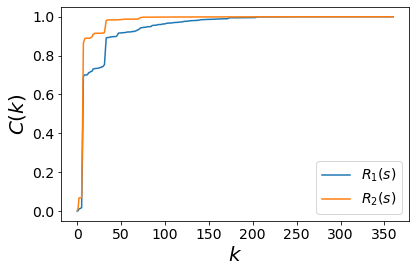

In [390]:
plt.plot(Ck1, label = r'$R_1(s)$')
plt.plot(Ck2, label = r'$R_2(s)$')
plt.legend()
plt.xlabel(r'$k$',fontsize =20)
plt.ylabel(r'$C(k)$',fontsize = 20)
plt.tight_layout()
plt.savefig(f'figures/Ck_curves_vary_target_place_cell_2d_MDP.pdf', bbox_inches = 'tight')
plt.show()

In [392]:
batch = 2
eta = 0.05


losses_MDP1 = TD_MDP_passPsi(Psi_spec, Sigma_emp, eta, gamma, R1, batch=batch)
losses_th1 = TD_theory_MDP_passSigma(Sigma_emp, eta, gamma, R1, batch = batch)


losses_MDP2 = TD_MDP_passPsi(Psi_spec, Sigma_emp, eta, gamma, R2, batch=batch)
losses_th2 = TD_theory_MDP_passSigma(Sigma_emp, eta, gamma, R2, batch = batch)


0.016723383
(361,)
(361,)
(361,)
(361, 19, 19)
0.041671455
(361,)
(361,)
(361,)
(361, 19, 19)


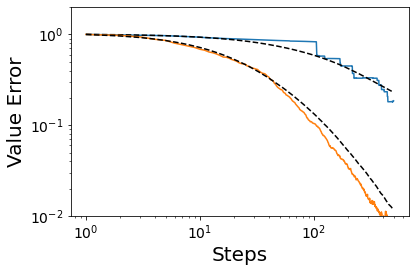

In [393]:
plt.figure()
plt.loglog(np.linspace(1,length,length), np.array(losses_MDP1) / losses_MDP1[0])
plt.loglog(np.linspace(1,length,length), np.array(losses_th1) / losses_th1[0], '--', color = 'black')
plt.loglog(np.linspace(1,length,length), np.array(losses_MDP2) / losses_MDP2[0])
plt.loglog(np.linspace(1,length,length), np.array(losses_th2) / losses_th2[0], '--', color = 'black')
plt.xlabel('Steps',fontsize = 20)
plt.ylabel('Value Error',fontsize = 20)
#plt.legend()
plt.ylim([1e-2,2.0])
plt.tight_layout()
plt.savefig(f'figures/vary_target_place_cell_2d_MDP_batch_{batch}.pdf', bbox_inches = 'tight')
#plt.savefig(f'figures/vary_place_width_2d_MDP_batch_{batch}.pdf')
plt.show()

In [190]:
place_cell_widths = [2,4,6]
all_A = []
all_wV = []
eta = 0.02
gamma = 0.9
batch = 5
for i, width in enumerate(place_cell_widths):
    Psi = construct_code(sigma = width)
    N = Psi.shape[0]
    R = construct_target_fn()
    Sigma_emp = get_emp_Sigma(Psi)
    A, wV = get_spectral_decomp_R_A(Sigma_emp, gamma, R)
    all_A += [A]
    all_wV += [wV]
    

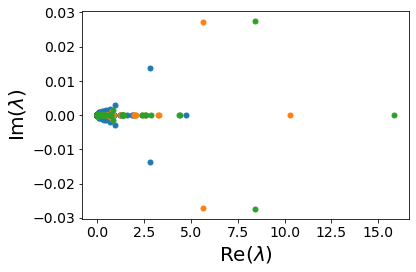

-1.0163907e-06
[4.7438865 2.82548   2.82548   1.9049777 1.8916367]
[[ 0.00701312+0.0000000e+00j -0.0002139 +7.0346781e-05j
  -0.0002139 -7.0346781e-05j -0.00013561+0.0000000e+00j]
 [ 0.00949923+0.0000000e+00j -0.00029102+9.5756652e-05j
  -0.00029102-9.5756652e-05j -0.00018156+0.0000000e+00j]
 [ 0.01009053+0.0000000e+00j -0.00030881+1.0021371e-04j
  -0.00030881-1.0021371e-04j -0.00017449+0.0000000e+00j]
 [ 0.01016833+0.0000000e+00j -0.00030409+9.2145980e-05j
  -0.00030409-9.2145980e-05j -0.00010949+0.0000000e+00j]]
-0.0001554654
[10.304528   5.646108   5.646108   3.2968233  3.25023  ]
[[ 0.00911674+0.j         -0.00022254-0.00010185j -0.00022254+0.00010185j
  -0.00016082+0.j        ]
 [ 0.01238086+0.j         -0.00029217-0.00015311j -0.00029217+0.00015311j
  -0.00026924+0.j        ]
 [ 0.01407081+0.j         -0.00031747-0.00018852j -0.00031747+0.00018852j
  -0.00033811+0.j        ]
 [ 0.01476218+0.j         -0.00033482-0.00018067j -0.00033482+0.00018067j
  -0.00022826+0.j        ]]
-0.0

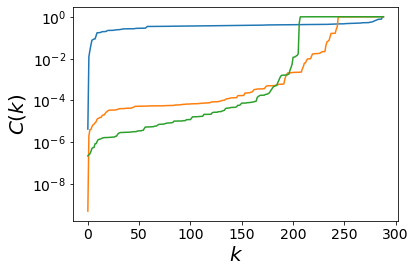

In [191]:
plt.figure()
for i, A in enumerate(all_A):
    s, v = np.linalg.eig(A)
    plt.scatter(s.real, s.imag, s = 25)
plt.xlabel(r'Re($\lambda$)',fontsize = 20)
plt.ylabel(r'Im($\lambda$)',fontsize = 20)
plt.tight_layout()
plt.savefig('figures/2D_mdp_eigenvals_vs_place_width.pdf')
plt.show()

plt.figure()
for i, A in enumerate(all_A):
    s,v = np.linalg.eig(A)
    real_s = s.real
    print(np.amin(real_s))
    ind_sort = np.argsort(real_s)[::-1]
    s = s[ind_sort]
    print(s[0:5].real)
    v = v[:,ind_sort]
    print(v[0:4,0:4])
    coeffs = np.absolute(jnp.linalg.solve(v, all_wV[i]))**2
    Ck = np.cumsum(coeffs)/np.sum(coeffs)
    plt.plot(Ck)
plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$C(k)$',fontsize = 20)
plt.yscale('log')
plt.tight_layout()
plt.savefig('figures/2D_mdp_Ck_vs_place_width.pdf')
plt.show()

## Reward Shaping

In [5]:
def expt_learn_curves_rshaped(Sigma_diag, sqrt_Sigma, wR, wV, wS, eta, gamma, batch, num_rep = 20, sigma = 0.0):
    
    w_fx = wV + wS
    def update_fn(w_key, x):
        w, key = w_key
        loss = jnp.sum((w-w_fx)**2 * Sigma_diag )
        Z = random.normal(key, (N,T, batch))
        psi = jnp.einsum('ijk,ikl->ijl', sqrt_Sigma, Z)
        psi0 = psi[:,:T-1,:]
        psi1 = psi[:,1:,:]
        
        # reward prediction error
        new_key, eps_key = random.split(key)
        
        # RPE should be deltat = (wR+wS-w)*psi_t + gamma*psi_{t+1}*(w-wS)
        RPE = jnp.einsum('ijk,i->jk', psi0, wR+wS-w) + gamma*jnp.einsum('ijk,i->jk', psi1, w-wS) + sigma*random.normal(eps_key, (psi0.shape[1],psi0.shape[2]))
        dw = eta/batch * jnp.einsum('ijk,jk->i', psi0, RPE)
        new_w = w + dw
        return [new_w, new_key], loss
    
    get_losses = lambda keynum: lax.scan(update_fn, [jnp.zeros(N), random.PRNGKey(keynum)], xs=None, length = steps)[1]
    all_losses = vmap(get_losses)(jnp.arange(20))
    
    return all_losses


# this shaping procedure changes the fixed point the algorithm converges to!! need to recompute wV = wV_old + wS
def compute_theory_rshaped(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, wS, eta, gamma,batch, sigma = 0.0):
    
    
    # <w_{n+1}> = < w_n > + eta \sum_{t} psi_t [ psi_t (wR + wS - <w>) + gamma psi_{t+1} * ( < w > - wS ) ]
    #           = < w_n > + eta [ Sigma (wR + wS - <w>) + gamma Sigma_+ (<w> - wS) ]
    #           = 
    # fixed point:   <w> = (Sigma-gamma Sigma_+)^{-1} Sigma wR + wS
    a = Sigma_diag - gamma * Sigma_shift_diag
    w_fx = wV + wS
    w_rs = wR + wS
    def update_fn_th(mwbar,x):
        m, w_bar = mwbar
        loss = jnp.sum( m * Sigma_diag )
        # compute Q(t,s)
        Sigma0 = Sigma[:,:T-1,:T-1]
        Sigma1 = Sigma[:,:T-1,1:]
        Sigma2 = Sigma[:,1:,1:]
        ww = m + 2*(w_bar-w_fx)*w_fx + w_fx**2 # < w w > = < (w-w_fx + wfx)(w-w_fx + wfx) > = M + 2(<w>-wfx)wfx + wfx^2
        # < (w-w_rs)^2 > = < w^2 > - 2 < w > wrs + wrs^2 
        w_wrs_sqr = ww - 2*w_bar * w_rs + w_rs**2
        # < (w_rs - w) * (w - wS) > = w_fx (<w> - wS) - <ww> + <w> wS
        w_wR_cross = w_rs*(w_bar-wS) - ww  + w_bar * wS
        # (w-wS)**2 = ww - 2 <w> wS + wS**2
        w_wS_sqr = ww - 2 * w_bar*wS + wS**2
        
        Q = jnp.einsum('ijk,i->jk', Sigma0, w_wrs_sqr) + gamma * jnp.einsum('ijk,i->jk', Sigma1, w_wR_cross) 
        Q += gamma * jnp.einsum('ijk,i->kj', Sigma1, w_wR_cross) + gamma**2 * jnp.einsum('ijk,i->jk', Sigma2, w_wS_sqr)
        Q += sigma**2 * jnp.eye(Sigma0.shape[1])
        m_new = (1-eta*a)**2 * m + eta**2/ batch * jnp.einsum('ijk,jk->i',Sigma0,Q)
        w_bar_new = w_bar + eta * a * (w_fx - w_bar)
        return [m_new, w_bar_new], loss

    m0 = w_fx**2    # m = < (w-w_V)^2 >
    w_bar0 = np.zeros(N)
    _, losses_th = lax.scan(update_fn_th, [m0,w_bar0], xs=None, length = steps)
    return losses_th

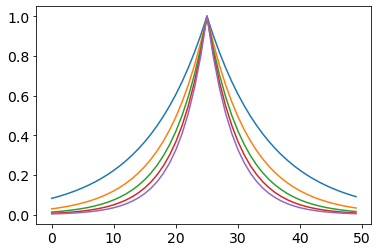

In [9]:
T = 50
N = 300
tau = 1.5

exp_spec = 1.2

Sigma = np.zeros((N,T,T))
Sigma_shift = np.zeros((N,T,T))
taus = [ 10.0/np.sqrt(n+1) for n in range(N) ]

for t in range(T):
    for s in range(T):
        for k in range(N):
            Sigma[k,t,s] = (k+1)**(-exp_spec) * np.exp(- np.abs(t-s) / taus[k] )

    
for k in range(5):
    plt.plot(Sigma[k,T//2,:] / Sigma[k,T//2,T//2])
plt.show()

Sigma_diag = np.zeros(N)
Sigma_shift_diag = np.zeros(N)
for t in range(T-1):
    Sigma_shift_diag += Sigma[:,t,t+1]
    Sigma_diag += Sigma[:,t,t]

steps = 500
eta = 0.025
w = np.zeros(N)
w_expt = np.zeros(N)
exp_target = 1.1
wR = np.array( [ (n+1)**(-exp_target) for n in range(N) ] )

gamma = 0.9
batch = 25
sqrt_Sigma = np.zeros((N,T,T))
for k in range(N):
    sqrt_Sigma[k,:,:] = sqrt_mat(Sigma[k,:,:])

sqrt_Sigma = jnp.array(sqrt_Sigma)

all_w = []
all_w_expt = []

wV = Sigma_diag / (Sigma_diag - gamma * Sigma_shift_diag) * wR
wS = 0.25*wV

In [27]:
losses_sh = expt_learn_curves_rshaped(Sigma_diag, sqrt_Sigma, wR, wV, wS, eta, gamma, batch, num_rep = 20, sigma = 0.0)
losses_th_sh= compute_theory_rshaped(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, wS, eta, gamma,batch, sigma = 0.0)

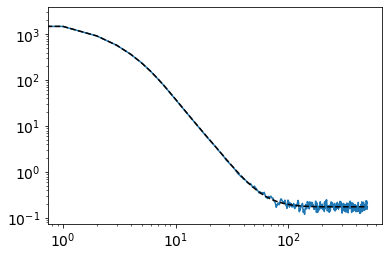

In [28]:
plt.loglog(losses_sh.mean(axis = 0))
plt.loglog(losses_th_sh,'--',color = 'black')
plt.show()

In [10]:
# sweep over reward shaping

shape_scales = [-0.8, -0.5, 0.0, 0.5, 1.0]
all_th_sh = []
all_expt_sh = []
for i, scale in enumerate(shape_scales):
    wS = scale * wV
    losses_sh = expt_learn_curves_rshaped(Sigma_diag, sqrt_Sigma, wR, wV, wS, eta, gamma, batch, num_rep = 20, sigma = 0.0)
    losses_th_sh= compute_theory_rshaped(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, wS, eta, gamma,batch, sigma = 0.0)
    all_th_sh += [losses_th_sh]
    all_expt_sh += [losses_sh]
    

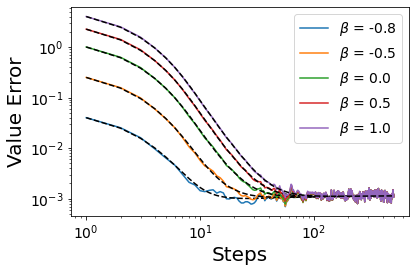

In [11]:
plt.rcParams.update({'font.size': 14})
plt.figure()
for i, scale in enumerate(shape_scales):
    length = len(all_th_sh[i])
    plt.loglog(jnp.linspace(1,length,length),all_expt_sh[i].mean(axis = 0) / all_th_sh[2][0], label = r'$\beta$ = %0.1f' % scale)
    plt.loglog(jnp.linspace(1,length,length), all_th_sh[i] / all_th_sh[2][0],'--',color = 'black')
plt.xlabel(r'Steps',fontsize = 20)
plt.ylabel(r'Value Error',fontsize = 20)
plt.legend()
plt.tight_layout()
#plt.savefig('figures/vary_rewardshape_gauss_decoupled.pdf')
plt.show()

In [41]:
# need a more clever way to do reward shaping... consider a rotation into a direction with higher signal

wR = np.zeros(N)
wR[15] = 1.0
wfast = np.zeros(N)
wfast[0] = 1.0

wV = Sigma_diag / (Sigma_diag - gamma * Sigma_shift_diag) * wR
# consider reshaping ops that keep power fixed 
batch = 30
theta_vals = [0.0, np.pi/4, np.pi/2.0]


all_th_sh = []
all_expt_sh = []
for i, theta in enumerate(theta_vals):
    wS = - wV + np.sin(theta)*wfast + np.cos(theta)*wV
    losses_sh = expt_learn_curves_rshaped(Sigma_diag, sqrt_Sigma, wR, wV, wS, eta, gamma, batch, num_rep = 20, sigma = 0.0)
    losses_th_sh= compute_theory_rshaped(Sigma, Sigma_diag, Sigma_shift_diag, wR, wV, wS, eta, gamma,batch, sigma = 0.0)
    all_th_sh += [losses_th_sh]
    all_expt_sh += [losses_sh]



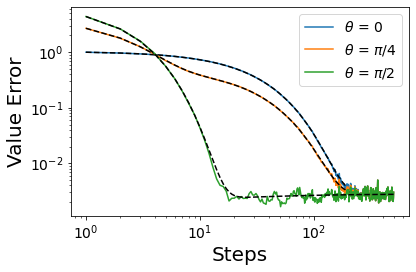

In [42]:
plt.rcParams.update({'font.size': 14})
plt.figure()
for i, theta in enumerate(theta_vals):
    length = len(all_th_sh[i])
    if i == 0:
        label_str = r'$\theta$ = 0'
    else:
        label_str = r'$\theta$ = $\pi /%d$' % (4//i)
    plt.loglog(jnp.linspace(1,length,length),all_expt_sh[i].mean(axis = 0) / all_th_sh[0][0], label = label_str)
    plt.loglog(jnp.linspace(1,length,length), all_th_sh[i] / all_th_sh[0][0],'--',color = 'black')
plt.xlabel(r'Steps',fontsize = 20)
plt.ylabel(r'Value Error',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/vary_rewardshape_rotate_gauss_decoupled.pdf')
plt.show()

In [ ]:
# think of a way to get ground truth value function... Can definitely do this for the MDP curve...
# why not just plot all experiments for the 2D exploration MDP? I guess these are kind of nice... 

# let's consider reward shaping in this 2d mdp...